In [1]:
from mantisshrimp.all import *

In [2]:
source = Path('../nbs/samples').absolute()
annot_json = json.load((source/'annotations.json').open())

In [6]:
parser = COCOParser(annot_json, source/'images')
records = parser.parse()


Removed 0 images that don't have annotations


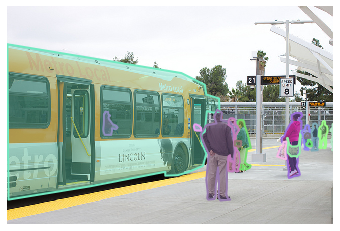

In [7]:
show_record(records[0])